In [ ]:
# Transfer Learning based approach (Exclude Top Layer, Freeze Base Layers, Add Custom Head)
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# --- 1. Setup and Configuration ---

# Define key parameters for the project
DATA_DIR = 'room_dataset'  # The directory containing your image folders
IMG_SIZE = (224, 224)      # VGG16 is optimized for 224x224 images
BATCH_SIZE = 8             # Batch size for training (adjust based on your GPU memory)
EPOCHS = 20                # Number of epochs to train for
LEARNING_RATE = 1e-4       # Learning rate for the Adam optimizer

In [3]:
# --- 2. Data Loading and Augmentation (Modernized) ---

# We will use ImageDataGenerator, a powerful Keras utility for loading and augmenting images.
# It automatically handles loading images from directories, resizing, batching, and label creation.

print("Setting up data generators with augmentation...")

# Create a data generator for the training set with data augmentation
# Data augmentation creates modified versions of images during training,
# which helps the model generalize better and prevents overfitting.
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Apply shear transformations
    zoom_range=0.2,              # Randomly zoom in on images
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest',         # How to fill in new pixels that may appear after transformations
    validation_split=0.2         # Reserve 20% of the data for validation
)

# Create a data generator for the validation set (no augmentation, just normalization)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

Setting up data generators with augmentation...


In [4]:
# Create the actual data generators from the directory
try:
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical', # For multi-class classification
        subset='training'         # Specify this is the training set
    )

    validation_generator = validation_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'       # Specify this is the validation set
    )

    # Get the number of classes and class labels
    num_classes = len(train_generator.class_indices)
    class_labels = list(train_generator.class_indices.keys())
    print(f"\nFound {train_generator.samples} training images belonging to {num_classes} classes.")
    print(f"Found {validation_generator.samples} validation images.")
    print(f"Class labels: {class_labels}")

except FileNotFoundError:
    print(f"\nERROR: The directory '{DATA_DIR}' was not found.")
    print("Please make sure your data is in a folder named 'room_dataset' in the same directory as this notebook.")
    num_classes = 2 # Set a default to allow the script to continue for demonstration

Found 19 images belonging to 2 classes.
Found 4 images belonging to 2 classes.

Found 19 training images belonging to 2 classes.
Found 4 validation images.
Class labels: ['bed_room', 'dining_room']


In [5]:
# --- 3. Build the Model using Transfer Learning (Modernized) ---

print("\nBuilding the model with VGG16 base...")

# Load the VGG16 model with weights pre-trained on ImageNet
# include_top=False removes the final classification layer (the "head")
# input_shape specifies the size of our images
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the layers of the base model.
# We do this so that their pre-trained weights are not updated during the initial training.
# This preserves the learned features from ImageNet.
base_model.trainable = False

# Create a new custom classification head to place on top of the base model
# This part of the model will be trained on our custom room dataset.
model = Sequential([
    base_model,                  # The frozen VGG16 base
    GlobalAveragePooling2D(),    # Reduces the feature map dimensions
    Dense(512, activation='relu'), # A fully connected layer
    Dropout(0.5),                # Dropout layer to prevent overfitting
    Dense(num_classes, activation='softmax') # The final output layer
])


Building the model with VGG16 base...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 46s 1us/step


In [6]:
# --- 4. Compile the Model ---

print("\nCompiling the model...")
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the final model architecture
model.summary()


Compiling the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Starting model training...
Epoch 1/20


c:\Users\shahs_snohmej\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5909 - loss: 0.6677 - val_accuracy: 0.5000 - val_loss: 0.6966
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6250 - loss: 0.6000

c:\Users\shahs_snohmej\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 932ms/step - accuracy: 0.6250 - loss: 0.6000 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4040 - loss: 0.9588 - val_accuracy: 0.5000 - val_loss: 0.6867
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 907ms/step - accuracy: 0.3750 - loss: 1.0043 - val_accuracy: 0.5000 - val_loss: 0.6817
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7576 - loss: 0.5690 - val_accuracy: 0.5000 - val_loss: 0.6712
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6250 - loss: 0.8137 - val_accuracy: 0.5000 - val_loss: 0.6662
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6667 - loss: 0.6510 - val_accuracy: 0.5000 - val_loss: 0.6560
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6667 - loss: 0.6614 - val_accuracy: 0.5000 - val_loss: 0.6504
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5833 - loss: 0.7415 - val_accuracy: 0.7500 - val_loss: 0.6403
Epoch 10/20
2/2 ━━━━━

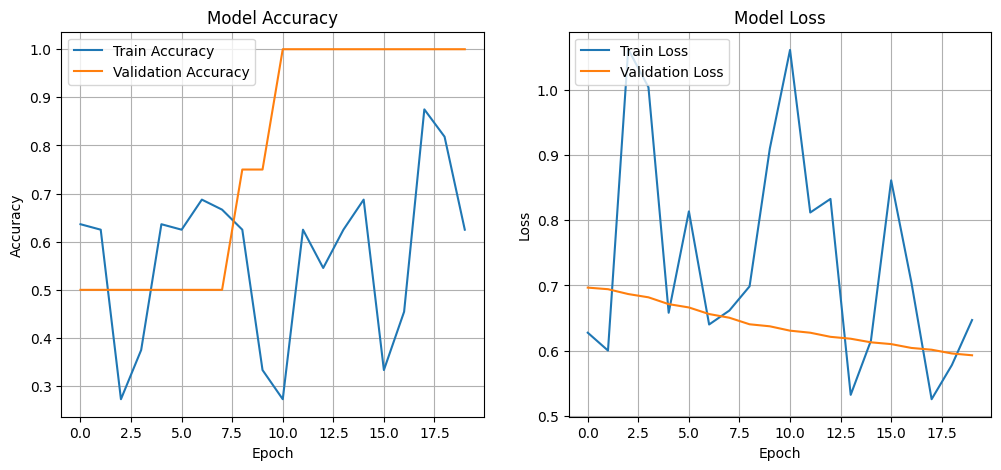

In [7]:
# --- 5. Train the Model ---

# Only proceed with training if the data was found
if 'train_generator' in locals():
    print("\nStarting model training...")

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    print("\nTraining finished.")


    # --- 6. Evaluate and Plot Results ---

    print("\nPlotting training history...")

    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()
else:
    print("\nSkipping training because data directory was not found.")
